# **Neural transition-based parsing for dependency grammars (unlabelled dependencies)**

##Natural Language Processing - Project 2022-2023

##Group members : **Sambin** Luca, **Sartor** Nicolò

## 0 - Introduction

Transition-based dependency parsing is one of the most popular methods for implementing a dependency parsers.  We use here the **arc-eager** model. We augment the parser with neural machinery for contextual word embeddings and for choosing the most appropriate parser actions.

We first implement the following features:
* **BiLSTM** representation for stack tokens
* **MLP** for next transition classification, based on **arc-eager**
* training under **static oracle**

We then develop a second model that uses **BERT** in place of the **BiLSTM**.

For training we use a dependency treebank from the Universal Dependency (UD) project.

In conclusion we focus our study on the following points:
- **Dataset analysis**: we describe the treebank and report any useful information, as for instance sentence length distribution.
- Description of **BiLSTM model** and **BERT-based model**.
- **Data set-up** and **training**.
- **Evaluation**: we use unlabeled attachment score (UAS). We draw a comparison between the two models and perform some error analysis for the BERT-based model.
- Brief discussion of **SotA** for this task

**We disregard arc labels in dependency trees.**

The reference **papers** are:
> Kiperwasser and Goldberg, Simple and Accurate Dependency Parsing Using Bidirectional LSTM Feature Representations
*Transactions of the Association for Computational Linguistics*, Volume 4, 2016.

> Yoav Goldberg and Joakim Nivre. 2012. A Dynamic Oracle for Arc-Eager Dependency Parsing. In Proceedings of COLING 2012, pages 959–976, Mumbai, India. The COLING 2012 Organizing Committee.

## 1 - Set-up Enviroment

In [1]:
!pip install datasets
!pip install conllu
!pip install evaluate
!pip install transformers
!pip install accelerate
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import evaluate
import seaborn as sns
import scipy.stats as st
from functools import partial
from datasets import load_dataset, Dataset
from matplotlib import pyplot
from transformers import AutoTokenizer, AutoModelForMaskedLM
from google.colab import files
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## 2 - Arc-eager Parser

Recall that a **configuration** of the arc-eager parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of arcs constructed so far.

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer.

The parser can perform four types of **actions** (transitions):
* **left-arc**, adds the arc (b, s) to A, where s is the node on top of the stack and b is the first node in the buffer, and pops the stack (it has as a precondition that the token s is not `<ROOT>` and does not already have a head);
* **right-arc**, adds the arc (s, b) to A, where s is the node on top of the stack and b is the first node in the buffer, and pushes the node b onto the stack;
* **reduce**, pops the stack and it is subject to the preconditions that the top token has a head;
* **shift**, removes the first node in the buffer and pushes it onto the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list.
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.

In [3]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift move to initialize the stack
    self.shift() # push <ROOT>

  def left_arc(self):
    b1 = self.buffer[0]
    o1 = self.stack.pop()
    self.arcs[o1] = b1

  def right_arc(self):
    b1 = self.buffer[0]
    o1 = self.stack[-1]
    self.arcs[b1] = o1
    self.shift()

  def reduce(self):
    self.stack.pop()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

## 3 - Static Oracle

A **static oracle** maps parser configurations $c$ into  actions, and it does so by looking into the gold (reference) tree for the sentence at hand.  If $c$ does not contain any mistake, then the action provided by the oracle for $c$ is guaranted to be correct.  Furthermore, in cases where there is more than one correct action for $c$, the oracle always chooses a single action, called the **canonical** action.

We use here the static oracle for the arc-eager parser. The oracle is based on the following conditions:
* set $A$ in configuration $c$ does not contain any wrong dependency;
* left-arc has precedence over other actions, it can be done only if it constructs a gold dependency, $\sigma_1$ is not `<ROOT>`, has already collected all of its dependents and does not have a head;
* right-arc can be done only if it constructs a gold dependency;
* reduce can be done only if $\sigma_1$ is not `<ROOT>`, has already collected all of its dependents and has a head;
* shift has the lowest precedence, it can be done if the buffer is not empty.

Thanks to these conditions the oracle implicitly defines a canonical transition sequence for every tree.

N.B. We have no guarantee for what happens if we apply the oracle to a
configuration that does not belong to the canonical transition sequence.

In [4]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    b1 = self.parser.buffer[0]
    o1 = self.parser.stack[-1]

    #if we don't have a gold dependency we don't need to do other checks
    if self.gold[o1] != b1:
      return False

    #if the <ROOT> is the only item in the stack
    if o1 == -1:
      return False

    #if sigma_1 does have a head
    if self.parser.arcs[o1] != -1:
      return False

    #we only check missing dependents for sigma_1
    #to the right of the first element of the buffer
    #since we assume A is correct and thus all left dependents
    #for sigma_1 have already been collected
    for i in self.parser.buffer[1:]:
      if self.gold[i] == o1:
        return False

    return True


  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    b1 = self.parser.buffer[0]
    o1 = self.parser.stack[-1]

    #we return true if we have a gold dependency and false otherwise
    return self.gold[b1] == o1

  def is_reduce_gold(self):
    if len(self.parser.stack) == 1:
      return False

    o1 = self.parser.stack[-1]

    #if sigma_1 does not have a head yet
    #N.B sigma_1 != <ROOT> thanks to the previous if
    if self.parser.arcs[o1] == -1:
      return False

    #we only check missing dependents for sigma_1
    #to the right of the first element of the buffer
    #since we assume A is correct and thus all left dependents
    #for sigma_1 have already been collected
    for i in self.parser.buffer[1:]:
      if self.gold[i] == o1:
        return False

    return True

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold()or self.is_reduce_gold()):
      return False

    return True

## 4 - Dataset

We use the huggingface [datasets](https://github.com/huggingface/datasets) library, and train on the English [treebank](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies) from the Universal Dependency project. We decided to use [UD English GUM Treebank](https://universaldependencies.org/treebanks/en_gum/index.html).

GUM, the Georgetown University Multilayer corpus, is an open source collection of richly annotated texts from multiple text types. The corpus is collected and expanded by students as part of the curriculum in the course LING-367 “Computational Corpus Linguistics” at Georgetown University. The selection of text types is meant to represent different communicative purposes, while coming from sources that are readily and openly available (usually Creative Commons licenses), so that new texts can be annotated and published with ease.

Furthermore, this corpus uses 17 UPOS tags: **ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X**.

In [38]:
dataset_name = 'en_gum'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_dataset = load_dataset('universal_dependencies', dataset_name, split="train")
dev_dataset = load_dataset('universal_dependencies', dataset_name, split="validation")
test_dataset = load_dataset('universal_dependencies', dataset_name, split="test")

Device: cuda


In [39]:
# Function that associate the pos_tag (number) to its correct value (string)
def convert_from_number_to_pos_tag(item):
  if item == 0: return 'ADJ'
  elif item == 1: return 'ADP'
  elif item == 2: return 'ADV'
  elif item == 3: return 'AUX'
  elif item == 4: return 'CCONJ'
  elif item == 5: return 'DET'
  elif item == 6: return 'INTJ'
  elif item == 7: return ''
  elif item == 8: return 'NOUN'
  elif item == 9: return 'NUM'
  elif item == 10: return 'PART'
  elif item == 11: return 'PRON'
  elif item == 12: return 'PROPN'
  elif item == 13: return 'PUNCT'
  elif item == 14: return 'SCONJ'
  elif item == 15: return 'SYM'
  elif item == 16: return 'VERB'
  elif item == 17: return 'X'
  else: return '?'

#function that counts how many of each pos_tag are there in a dataset and return a dictionary
def pos_tag_count(dataset):
  # Create a dictionary to store pos_tag
  num_pos_counts = {}

  # Iterate through the dataset and count POS tags
  for item in dataset:
      for idx, _ in enumerate(item["tokens"]):
          # Extract the POS tag from the token
          pos_tag = item['upos'][idx]
          #print(pos_tag)
          if pos_tag in num_pos_counts:
              num_pos_counts[pos_tag] += 1
          else:
              num_pos_counts[pos_tag] = 1

  # Extract the POS tags (it's a number) and their corresponding counts
  pos_tag_num_list = list(num_pos_counts.keys())
  count_list = list(num_pos_counts.values())

  pos = {}
  for ptag_num, c in zip(pos_tag_num_list, count_list):
    # Convert from pos_tag number to its corresponding value
    pos_tag = convert_from_number_to_pos_tag(ptag_num)
    pos[pos_tag] = c
  return pos

#we store now the pos tag stats before preprocessing and print them later
train_pos_bp = pos_tag_count(train_dataset)

In [40]:
#Store some statistics about dataset before preprocessing for the analysis
train_sentences_length_bp = [len(s) for s in train_dataset['tokens']]

train_dataset_len_bp = len(train_dataset)

### 4.1 - Preprocessing

To run the **arc-eager parser** we need a **classifier** that looks at some of the content of the current parser configuration and selects an approapriate action. In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action.

First of all, we need to preprocess the training set. We remove non-projective trees. We also create a dictionary of word/index pairs, to be used later when creating word embeddings for the BiLSTM model. Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.

In [41]:
# the function returns whether a tree is projective or not.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# this function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [42]:
# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

### 4.2 - Dataset Analysis

We observe the length of each subset of data before and after preprocessing, we analize with how many unique words we are working with and finally we study the distribution of the sentences length and of the POS TAGs plotting the results


In [43]:
print('\033[1m' + "Number of senteces before removing non-projective senteces" + '\033[0m')
print("Number of sentence in the dataset:", train_dataset_len_bp+len(dev_dataset)+len(test_dataset))
print("Number of sentence in Training set: ", train_dataset_len_bp)
print("Number of sentence in Validation set: ", len(dev_dataset))
print("Number of sentence in Test set: ", len(test_dataset))
print("\n" + '\033[1m' + "Number of senteces after removing non-projective senteces" + '\033[0m')
print("Number of sentence in the dataset: ", len(train_dataset)+len(dev_dataset)+len(test_dataset))
print("Number of sentence in Training set: ", len(train_dataset))
print("Number of sentence in Validation set: ", len(dev_dataset))
print("Number of sentence in Test set: ", len(test_dataset))
print("\n" + '\033[1m' + "Number of sentences successfully removed during preprocessing: ", train_dataset_len_bp-len(train_dataset), '\033[0m')
print("\n" + '\033[1m' + "Number of unique words in the dataset: ", len(emb_dictionary), '\033[0m')

Number of senteces before removing non-projective senteces
Number of sentence in the dataset: 5961
Number of sentence in Training set:  4287
Number of sentence in Validation set:  784
Number of sentence in Test set:  890

Number of senteces after removing non-projective senteces
Number of sentence in the dataset:  5729
Number of sentence in Training set:  4055
Number of sentence in Validation set:  784
Number of sentence in Test set:  890

Number of sentences successfully removed during preprocessing:  232 

Number of unique words in the dataset:  3443 


Now we compute the probability distribution and the relative parameters based on the distribution of the length of the sentences of each subset.

We first define an utility function to compute the probability distribution and the relative parameters, later we will compute the results for our Dataset.

In [44]:
#function to compute best distribution and parameters that fit our data
def get_best_distribution(data):
  dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
  dist_results = []
  params = {}
  for dist_name in dist_names:
    dist = getattr(st, dist_name)
    param = dist.fit(data)

    params[dist_name] = param
    # Applying the Kolmogorov-Smirnov test
    D, p = st.kstest(data, dist_name, args=param)
    dist_results.append((dist_name, p))

  # select the best fitted distribution
  best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
  # store the name of the best fit and its p value

  return best_dist, best_p, params[best_dist]

Now we plot the length distibution of our Dataset as well as compute and plot the approximated distribution probability

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:1863: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +
<ipython-input-45-09bc1486845c>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  pyplot.style.use('seaborn')


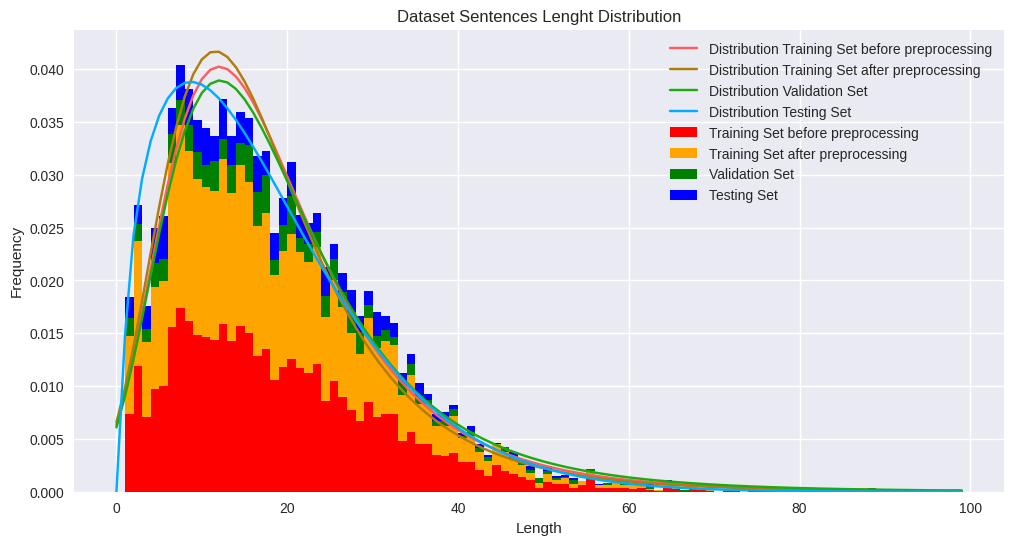


 Dataset                          | Distribution   |     P Value | Parameters
----------------------------------+----------------+-------------+---------------------------------------------------------------
 Training Set before prepocessing | genextreme     | 1.74711e-07 | (-0.09603050092842291, 12.860913083270354, 9.184694483116559)
 Training Set after prepocessing  | genextreme     | 1.51079e-07 | (-0.09678401856386756, 12.39092234019489, 8.862577023197858)
 Validation Set                   | genextreme     | 0.0721044   | (-0.12022140454060973, 13.17053563063567, 9.516180827785632)
 Testing Set                      | weibull_min    | 0.159208    | (1.4253827663896692, 0.581292342195183, 19.00215711058408)


In [45]:
train_sentences_length_ap = [len(s['tokens']) for s in train_dataset]
dev_sentences_length = [len(s) for s in dev_dataset['tokens']]
test_sentences_length = [len(s) for s in test_dataset['tokens']]

#Now we compute the approximated distribution probability parameters
train_bp_dist_name, train_bp_p, train_bp_param = get_best_distribution(train_sentences_length_bp)
train_ap_dist_name, train_ap_p, train_ap_param = get_best_distribution(train_sentences_length_ap)
dev_dist_name, dev_p, dev_param = get_best_distribution(dev_sentences_length)
test_dist_name, test_p, test_param = get_best_distribution(test_sentences_length)

#And now we plot everything
x=np.arange(100)
labels = ['Training Set before preprocessing', 'Training Set after preprocessing', 'Validation Set', 'Testing Set']

pyplot.style.use('seaborn')
pyplot.figure(figsize=(12, 6))

train_bp_dist = getattr(st, train_bp_dist_name)
train_bp_dist = train_bp_dist.pdf(x, *train_bp_param)
pyplot.plot(x, train_bp_dist, color="#ff5c5c", label='Distribution Training Set before preprocessing')

train_ap_dist = getattr(st, train_ap_dist_name)
train_ap_dist = train_ap_dist.pdf(x, *train_ap_param)
pyplot.plot(x, train_ap_dist, color="#b07c0b", label='Distribution Training Set after preprocessing')

dev_dist = getattr(st, dev_dist_name)
dev_dist = dev_dist.pdf(x, *dev_param)
pyplot.plot(x, dev_dist, color="#1eab11", label='Distribution Validation Set')

test_dist = getattr(st, test_dist_name)
test_dist = test_dist.pdf(x, *test_param)
pyplot.plot(x, test_dist, color="#00aeff", label='Distribution Testing Set')

pyplot.hist([train_sentences_length_bp, train_sentences_length_ap, dev_sentences_length, test_sentences_length],
         bins=x, color=["red", "orange", "green", "blue"], label=labels, density=True, stacked=True)

pyplot.xlabel("Length")
pyplot.ylabel("Frequency")
pyplot.title("Dataset Sentences Lenght Distribution")
pyplot.legend(loc='best')
pyplot.show()

#Build a table to show the results of the distributions previously computed
print()
table_head = ["Dataset","Distribution", "P Value", "Parameters"]
table_row = []

table_row.append(["Training Set before prepocessing", train_bp_dist_name, train_bp_p, train_bp_param])
table_row.append(["Training Set after prepocessing", train_ap_dist_name, train_ap_p, train_ap_param])
table_row.append(["Validation Set", dev_dist_name, dev_p, dev_param])
table_row.append(["Testing Set", test_dist_name, test_p, test_param])

print(tabulate(table_row, headers=table_head, tablefmt="presto", floatfmt=(".7f", ".5f")))

And finally we plot the POS TAG distibution of our Dataset

<ipython-input-46-29c3b5dc705e>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  pyplot.style.use('seaborn')


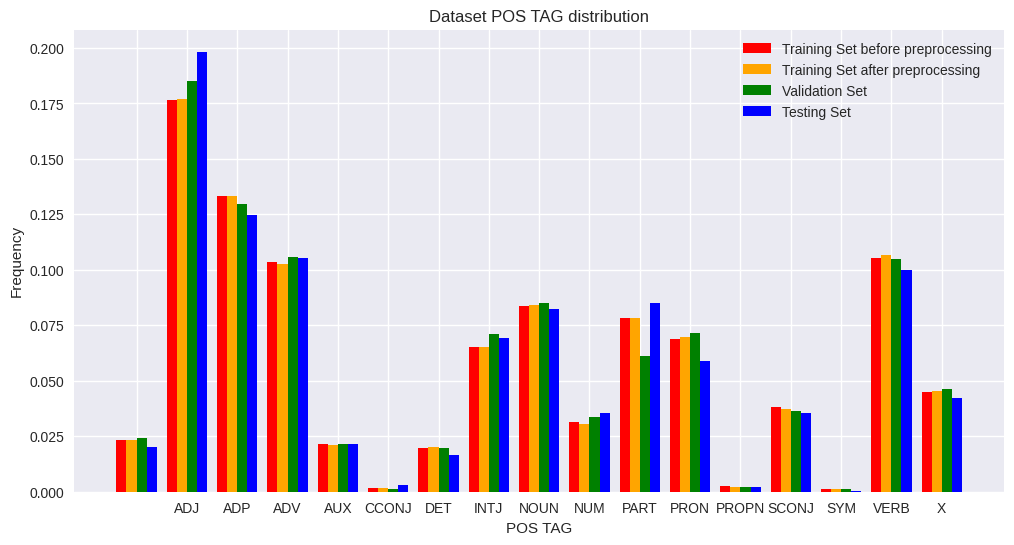

In [46]:
train_pos_bp = dict(sorted(train_pos_bp.items(), key=lambda item: item[0]))
train_pos_ap = pos_tag_count(train_dataset)
train_pos_ap = dict(sorted(train_pos_ap.items(), key=lambda item: item[0]))
dev_pos = pos_tag_count(dev_dataset)
dev_pos = dict(sorted(dev_pos.items(), key=lambda item: item[0]))
test_pos = pos_tag_count(test_dataset)
test_pos = dict(sorted(test_pos.items(), key=lambda item: item[0]))

# Numbers of pairs of bars
N = len(train_pos_bp)
# Position of bars on x-axis
ind = np.arange(N)
# Width of a bar
width = 0.2

pyplot.style.use('seaborn')
pyplot.figure(figsize=(12,6))

pyplot.bar(ind, np.divide(list(train_pos_bp.values()), sum(train_pos_bp.values())) , width, label='Training Set before preprocessing', color="red")
pyplot.bar(ind + width, np.divide(list(train_pos_ap.values()), sum(train_pos_ap.values())), width, label='Training Set after preprocessing', color="orange")
pyplot.bar(ind + 2*width, np.divide(list(dev_pos.values()), sum(dev_pos.values())), width, label='Validation Set', color="green")
pyplot.bar(ind + 3*width, np.divide(list(test_pos.values()), sum(test_pos.values())), width, label='Testing Set', color="blue")

pyplot.xlabel("POS TAG")
pyplot.ylabel("Frequency")
pyplot.title("Dataset POS TAG distribution")
pyplot.xticks(ind+width*3/2, train_pos_bp.keys())
pyplot.legend(loc='best')
pyplot.show()

## 5 - BiLSTM Model

### 5.1 - Parameters

In [47]:
#Parameters BiLSTM Model
LSTM_BATCH_SIZE = 16 #32
LSTM_EMBEDDING_SIZE = 300 #200
LSTM_SIZE = 300 #200
LSTM_LAYERS = 2 #1
LSTM_MLP_SIZE = 200
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 30
LSTM_LR = 0.001 #learning rate

### 5.2 - Data Set-Up
For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree. We then pair configurations and canonical actions. Since our neural classifier will look only into σ1, σ2 and β1, we do not have to record the full parser configuration.

Finally, we create dataloaders for train, development and test sets.

In [48]:
# This function is used to process our data and create the actual training samples
# for our BiLSTM model
def process_sample_lstm(sample, get_gold_path = False):
  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      # save configuration
      configuration = []
      if len(parser.stack) == 1:
        configuration = [-1, parser.stack[0]]
      else:
        configuration = [parser.stack[-2], parser.stack[-1]]

      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])

      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)


  return enc_sentence, gold_path, gold_moves, gold

# This function is used to batch the training data for our BiLSTM model
def prepare_batch_lstm(batch_data, get_gold_path=False):
  data = [process_sample_lstm(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

We create dataloaders for train, development and test sets

In [49]:
train_dataloader_bilstm = torch.utils.data.DataLoader(train_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_lstm, get_gold_path=True))
dev_dataloader_bilstm = torch.utils.data.DataLoader(dev_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_lstm))
test_dataloader_bilstm = torch.utils.data.DataLoader(test_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_lstm))

### 5.3 - Model Class
This class implement our model. It consists of a Bi-LSTM to represent words together with their contexts and a feedforward network to predict the next move of the parser.

In [50]:
class Net_LSTM(nn.Module):

  def __init__(self, device):
    super(Net_LSTM, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), LSTM_EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(LSTM_EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=LSTM_DROPOUT)

    # initialize feedforward
    self.w1 = nn.Linear(6*LSTM_SIZE, LSTM_MLP_SIZE, bias=True)
    self.activation = nn.Tanh()
    self.w2 = nn.Linear(LSTM_MLP_SIZE, out_features=4, bias=True)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(LSTM_DROPOUT)

  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat(
            [zero_tensor if j[0]==-1 else h[j[0]][i],
             zero_tensor if j[1]==-1 else h[j[1]][i],
             zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):
    parsers = [ArcEager(i) for i in x]
    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]
    h = self.lstm_pass(x)
    confusion = np.zeros((4,4))

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      confusion += self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree and the confusion matrix, which is useful for testing
    return [parser.arcs for parser in parsers], confusion

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if len(parser.stack) == 1:
        conf = [-1, parser.stack[0]]
      else:
        conf = [parser.stack[-2], parser.stack[-1]]
      if len(parser.buffer) == 0:
        conf.append(-1)
      else:
        conf.append(parser.buffer[0])

      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    confusion = np.zeros((4,4))
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:#Left arc
          #Priority: LA -> RA -> RE -> SH
          if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
            parsers[i].left_arc()
            confusion[0,0] += 1
          else:
            if len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[0,1] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[0,3] += 1
            else:
              parsers[i].shift()
              confusion[0,2] += 1
        elif moves_argm[i] == 1:#Right arc
          #Priority: RA -> LA -> RE -> SH
          if len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
            parsers[i].right_arc()
            confusion[1,1] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[1,0] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[1,3] += 1
            else:
              parsers[i].shift()
              confusion[1,2] += 1
        elif moves_argm[i] == 2:#Shift
          #Priority: SH -> LA -> RA -> RE
          if len(parsers[i].buffer) > 0:
            parsers[i].shift()
            confusion[2,2] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[2,0] += 1
            elif len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[2,1] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[2,3] += 1
        elif moves_argm[i] == 3:#Reduce
        #Priority: RE -> LA -> RA -> SH
          if len(parsers[i].stack) > 1:
            parsers[i].reduce()
            confusion[3,3] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[3,0] += 1
            elif len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[3,1] += 1
            else:
              parsers[i].shift()
              confusion[3,2] += 1

    return confusion

### 5.4 - Train

Now that we have defined all the components of our BiLSTM model, we are ready to train and test it.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [51]:
# Evaluation
def evaluate_bilstm(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

We define our train loop and the test function to run inference.

In [52]:
# Training
def train_bilstm(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    output = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(output, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test_bilstm(model, dataloader):
  model.eval()
  gold = []
  preds = []
  confusion = np.zeros((4,4))
  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred, conf = model.infere(sentences)
      gold += trees
      preds += pred
      confusion += conf

  return evaluate_bilstm(gold, preds), confusion

Finally, we run the training of our neural dependency parser.

In [53]:
bilstm_model = Net_LSTM(device)
bilstm_model.to(device)

bilstm_criterion = nn.CrossEntropyLoss()
bilstm_optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=LSTM_LR)

current_max_score = 0
no_improvement = 0
for epoch in range(LSTM_EPOCHS):
  avg_train_loss_bilstm = train_bilstm(bilstm_model, train_dataloader_bilstm, bilstm_criterion, bilstm_optimizer)
  val_uas_bilstm, _ = test_bilstm(bilstm_model, dev_dataloader_bilstm)

  # Check if the trained model is the best so far
  if val_uas_bilstm > current_max_score:
    torch.save(bilstm_model.state_dict(), 'bilstm_model.pth')
    current_max_score = val_uas_bilstm
    no_improvement = 0
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | -> Model saved".format( epoch, avg_train_loss_bilstm, val_uas_bilstm))
  else:
    no_improvement += 1
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss_bilstm, val_uas_bilstm))

  # If after 5 iteration the model doesn't improve, then stop and load the best model
  if no_improvement >= 5:
    print("No improvement after 5 iterations")
    break

# Load the best model, the one with higher validation accuracy
bilstm_state_dict = torch.load('bilstm_model.pth')
bilstm_model.load_state_dict(bilstm_state_dict)
print("The best BiLSTM model is loaded")

Epoch:   0 | avg_train_loss: 0.975 | dev_uas: 0.588 | -> Model saved
Epoch:   1 | avg_train_loss: 0.887 | dev_uas: 0.630 | -> Model saved
Epoch:   2 | avg_train_loss: 0.857 | dev_uas: 0.639 | -> Model saved
Epoch:   3 | avg_train_loss: 0.839 | dev_uas: 0.671 | -> Model saved
Epoch:   4 | avg_train_loss: 0.827 | dev_uas: 0.674 | -> Model saved
Epoch:   5 | avg_train_loss: 0.818 | dev_uas: 0.677 | -> Model saved
Epoch:   6 | avg_train_loss: 0.810 | dev_uas: 0.686 | -> Model saved
Epoch:   7 | avg_train_loss: 0.805 | dev_uas: 0.694 | -> Model saved
Epoch:   8 | avg_train_loss: 0.799 | dev_uas: 0.695 | -> Model saved
Epoch:   9 | avg_train_loss: 0.795 | dev_uas: 0.701 | -> Model saved
Epoch:  10 | avg_train_loss: 0.791 | dev_uas: 0.702 | -> Model saved
Epoch:  11 | avg_train_loss: 0.788 | dev_uas: 0.696 |
Epoch:  12 | avg_train_loss: 0.786 | dev_uas: 0.701 |
Epoch:  13 | avg_train_loss: 0.784 | dev_uas: 0.707 | -> Model saved
Epoch:  14 | avg_train_loss: 0.782 | dev_uas: 0.696 |
Epoch:  15

## 6 - BERT-based Model

This model (**Net_BERT**) uses BERT to extract the embeddings of the first token (leftmost) of each word that is then used to construct the configurations $[σ1, σ2, β1]$ passed to the MLP that will predict the next move.

In particular the embeddings are obtained by extracting the last 4 layers of BERT and summing them, this is in order to have more local information and a less targeted embedding compared to the original objective of the pre-train BERT model. We also tried extracting only the last layer but got worse evaluation on out validation set.


More information about the BERT model used [here](https://huggingface.co/bert-base-uncased)

### 6.1 - Parameters

In [21]:
#Parameters BERT-based Model
BERT_BATCH_SIZE = 8
BERT_EMBEDDING_SIZE = 200
BERT_OUT_FEATURES = 768
BERT_MLP_SIZE = 200
BERT_DROPOUT = 0.2
BERT_EPOCHS = 10
BERT_LR = 3e-5

### 6.2 - Data Set-Up

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree. We then pair configurations and canonical actions. Since our neural classifier will look only into σ1, σ2 and β1, we do not have to record the full parser configuration. Compared to the biLSTM Model we now have to use a tokenizer and need to be particularly carefull since our words can be splitted into more than 1 token. We in fact save the correlation between each token and its original word in the sentence.

Finally, we create dataloaders for train, development and test sets.

In [22]:
# This function is used to process our data and create the actual training samples
# for our BERT-based model
def process_sample_bert(sample, aTokenizer, get_gold_path = False):
  # Tokenize the tokens using the pretrained BERT tokenizer
  # Since we’re dealing with already-split tokens rather than full sentence strings
  # we use is_split_into_words=True to tell this to the tokenizer
  sample_tokenized = aTokenizer(sample["tokens"], truncation=True, is_split_into_words=True, padding='max_length', max_length=BERT_EMBEDDING_SIZE)

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      # save configuration
      configuration = []
      if len(parser.stack) == 1:
        configuration = [-1, parser.stack[0]]
      else:
        configuration = [parser.stack[-2], parser.stack[-1]]

      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])

      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  # Constructs the list which is used to connect BERT's token embeddings
  # to the actual words in the sample.
  token_to_word = []
  token_to_word.append(1)
  for i, word in enumerate(sample["tokens"]):
    token_to_word.append(sample_tokenized.word_ids().index(i))

  return enc_sentence, gold_path, gold_moves, gold, sample_tokenized['input_ids'], token_to_word, sample_tokenized['attention_mask']

# This function is used to batch the training data for our BERT-based model
def prepare_batch_bert(batch_data, aTokenizer, get_gold_path=False):
  data = [process_sample_bert(sentence, get_gold_path=get_gold_path, aTokenizer=aTokenizer) for sentence in batch_data]
  # sentences, paths, moves, trees, input_ids, token_to_word, attention_mask are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  input_ids = [s[4] for s in data]
  token_to_word =  [s[5] for s in data]
  attention_mask = [s[6] for s in data]
  return sentences, paths, moves, trees, input_ids, token_to_word, attention_mask

We create dataloaders for train, development and test sets using the tokenizer matched with our pre-trained BERT model.

In [23]:
# Initialize the BERT tokenizer using the "bert-base-uncased" model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load original dataset
train_dataset = load_dataset('universal_dependencies', dataset_name, split="train")
dev_dataset = load_dataset('universal_dependencies', dataset_name, split="validation")
test_dataset = load_dataset('universal_dependencies', dataset_name, split="test")

# Remove non projective trees
train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]

# Create the dataloaders and tokenize the tokens using BERT tokenizer
train_dataloader_bert = torch.utils.data.DataLoader(train_dataset, batch_size=BERT_BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_bert, aTokenizer=tokenizer, get_gold_path=True))
dev_dataloader_bert = torch.utils.data.DataLoader(dev_dataset, batch_size=BERT_BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert, aTokenizer=tokenizer))
test_dataloader_bert = torch.utils.data.DataLoader(test_dataset, batch_size=BERT_BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_bert, aTokenizer=tokenizer))

### 6.3 - Model Class
This class implement our model. It consists of a first phase that uses a BERT model to represent words together with their contexts and a second phase that uses a feedforward network to predict the next move of the parser.

In [24]:
class Net_BERT(nn.Module):

  def __init__(self, device):
    super(Net_BERT, self).__init__()
    self.device = device

    # initialize BERT
    self.bert = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states=True)

    # initialize feedforward
    self.w1 = nn.Linear(3*BERT_OUT_FEATURES, BERT_MLP_SIZE, bias=True)
    self.activation = nn.Tanh()
    self.w2 = nn.Linear(BERT_MLP_SIZE, 4, bias=True)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(BERT_DROPOUT)


  def forward(self, x, paths, token_to_word, attention_mask):
    # run BERT
    h = self.bert_pass(x, attention_mask)

    # for each parser configuration that we need to score we arrange from the
    # output of BERT the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h, token_to_word)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def bert_pass(self, x_input_ids, x_attention_mask):
    # Tensor initialization
    x_input_ids = torch.tensor([x_input_ids]).to(self.device)
    x_input_ids = torch.squeeze(x_input_ids, 0) #since x is (1, batch_size, seq_len)
    x_attention_mask = torch.tensor([x_attention_mask]).to(self.device)
    x_attention_mask = torch.squeeze(x_attention_mask, 0)

    # BERT pass and last layer extraction
    h = self.bert(input_ids=x_input_ids, attention_mask=x_attention_mask)
    h = torch.stack(h.hidden_states[-4:]).sum(0) #h: (batch, length_sentences, output_hidden_units)
    h = h.permute(1,0,2) #h: (length_sentences, batch, output_hidden_units)

    return h

  def get_mlp_input(self, configurations, h, token_to_word):
    mlp_input = []
    zero_tensor = torch.zeros(BERT_OUT_FEATURES, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[ token_to_word[i][ j[0] ] ][i],
                                    zero_tensor if j[1]==-1 else h[ token_to_word[i][ j[1] ] ][i],
                                    zero_tensor if j[2]==-1 else h[ token_to_word[i][ j[2] ] ][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x, sentences, attention, token_to_word):
    parsers = [ArcEager(i) for i in sentences]
    h = self.bert_pass(x, attention)
    confusion = np.zeros((4,4))

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, token_to_word)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      confusion += self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree and the confusion matrix, which is useful for testing
    return [parser.arcs for parser in parsers], confusion

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if len(parser.stack) == 1:
        conf = [-1, parser.stack[0]]
      else:
        conf = [parser.stack[-2], parser.stack[-1]]
      if len(parser.buffer) == 0:
        conf.append(-1)
      else:
        conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    confusion = np.zeros((4,4))
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:#Left arc
          #Priority: LA -> RA -> RE -> SH
          if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
            parsers[i].left_arc()
            confusion[0,0] += 1
          else:
            if len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[0,1] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[0,3] += 1
            else:
              parsers[i].shift()
              confusion[0,2] += 1
        elif moves_argm[i] == 1:#Right arc
          #Priority: RA -> LA -> RE -> SH
          if len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
            parsers[i].right_arc()
            confusion[1,1] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[1,0] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[1,3] += 1
            else:
              parsers[i].shift()
              confusion[1,2] += 1
        elif moves_argm[i] == 2:#Shift
          #Priority: SH -> LA -> RA -> RE
          if len(parsers[i].buffer) > 0:
            parsers[i].shift()
            confusion[2,2] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[2,0] += 1
            elif len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[2,1] += 1
            elif len(parsers[i].stack) > 1:
              parsers[i].reduce()
              confusion[2,3] += 1
        elif moves_argm[i] == 3:#Reduce
        #Priority: RE -> LA -> RA -> SH
          if len(parsers[i].stack) > 1:
            parsers[i].reduce()
            confusion[3,3] += 1
          else:
            if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
              parsers[i].left_arc()
              confusion[3,0] += 1
            elif len(parsers[i].stack) > 1 and len(parsers[i].buffer) > 0:
              parsers[i].right_arc()
              confusion[3,1] += 1
            else:
              parsers[i].shift()
              confusion[3,2] += 1

    return confusion

### 6.4 - Train
Now that we have defined all the components of our BERT model, we are ready to train and test it.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [25]:
# Evaluation
def evaluate_bert(gold, preds):
  total = 0
  correct = 0
  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

We define our train loop and the test function to run inference.

In [26]:
# Training
def train_bert(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees, indices_ids, token_to_word, attention_mask = batch
    output = model(indices_ids, paths, token_to_word, attention_mask)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(output, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test_bert(model, dataloader):
  model.eval()
  gold = []
  preds = []
  confusion = np.zeros((4,4))
  for batch in dataloader:
    sentences, paths, moves, trees, indices_ids , token_to_word, attention_mask = batch
    with torch.no_grad():
      pred, conf = model.infere(indices_ids, sentences, attention_mask, token_to_word)
      gold += trees
      preds += pred
      confusion += conf

  return evaluate_bert(gold, preds), confusion

Finally, we run the training of our neural dependency parser.

In [27]:
bert_model = Net_BERT(device)
bert_model.to(device)

bert_criterion = nn.CrossEntropyLoss()
bert_optimizer = torch.optim.Adam(bert_model.parameters(), lr=BERT_LR)

current_max_score = 0
no_improvement = 0

for epoch in range(BERT_EPOCHS):
  avg_train_loss_bert = train_bert(bert_model, train_dataloader_bert, bert_criterion, bert_optimizer)
  val_uas_bert, _ = test_bert(bert_model, dev_dataloader_bert)

  # Check if the trained model is the best so far
  if val_uas_bert > current_max_score:
    torch.save(bert_model.state_dict(), 'bert_model.pth')
    current_max_score = val_uas_bert
    no_improvement = 0
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} | -> Model saved".format( epoch, avg_train_loss_bert, val_uas_bert))
  else:
    no_improvement += 1
    print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss_bert, val_uas_bert))

  # If after 3 iteration the model doesn't improve, then stop and load the best model
  if no_improvement >= 3:
    print("No improvement after 3 iterations")
    break

# Load the best model, the one with higher validation accuracy
bert_state_dict = torch.load('bert_model.pth')
bert_model.load_state_dict(bert_state_dict)
print("The best BERT model is loaded")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:   0 | avg_train_loss: 0.900 | dev_uas: 0.828 | -> Model saved
Epoch:   1 | avg_train_loss: 0.800 | dev_uas: 0.857 | -> Model saved
Epoch:   2 | avg_train_loss: 0.782 | dev_uas: 0.863 | -> Model saved
Epoch:   3 | avg_train_loss: 0.774 | dev_uas: 0.864 | -> Model saved
Epoch:   4 | avg_train_loss: 0.769 | dev_uas: 0.864 | -> Model saved
Epoch:   5 | avg_train_loss: 0.765 | dev_uas: 0.870 | -> Model saved
Epoch:   6 | avg_train_loss: 0.763 | dev_uas: 0.869 |
Epoch:   7 | avg_train_loss: 0.760 | dev_uas: 0.870 |
Epoch:   8 | avg_train_loss: 0.759 | dev_uas: 0.871 | -> Model saved
Epoch:   9 | avg_train_loss: 0.757 | dev_uas: 0.872 | -> Model saved
The best BERT model is loaded


## 7 - Conclusions and Discussion

### 7.1 - BiLSTM Evaluation
Test the BiLSTM model on the test set previously defined.

In [54]:
# Save also the confusion matrix between predicted moves and actual available moves
test_uas_bilstm, confusion_matrix_bilstm = test_bilstm(bilstm_model, test_dataloader_bilstm)
print("test_uas_bilstm: {:5.3f}".format(test_uas_bilstm))

test_uas_bilstm: 0.704


### 7.2 - BERT Evaluation
Test the BERT model on the test set previously defined.

In [29]:
# Save also the confusion matrix between predicted moves and actual available moves
test_uas_bert, confusion_matrix_bert = test_bert(bert_model, test_dataloader_bert)
print("test_uas_bert: {:5.3f}".format(test_uas_bert))

test_uas_bert: 0.857


### 7.3 - Error analysis
The error analysis focuses on the predicted next move guessed by the entire model and the actual move made due to ArcEager model constraints (e.g. making a **Reduce** on the **ROOT** if the buffer is empty).

This analysis is done by inspecting the respective confusion matrix and computing the relative accuracy for each labels:
- Left Arc
- Right Arc
- Shift
- Reduce

and F1 score of the two model that we have perviuosly tested in the test set.

In [30]:
# This function allow us to display the given confusion matrix in a graph form
def compute_confusion(confusion, all_labels, title, color):
  heatmap_moves_bilstm = sns.heatmap(confusion, linewidth=0.5, cmap=color)

  # Set the x and y tick labels for the given confusion matrix
  heatmap_moves_bilstm.set_xticklabels(all_labels)
  heatmap_moves_bilstm.set_yticklabels(all_labels)
  heatmap_moves_bilstm.set_xlabel('Predicted move')
  heatmap_moves_bilstm.set_ylabel('Actual move')

  # Set the title for grpah
  heatmap_moves_bilstm.set_title(title)

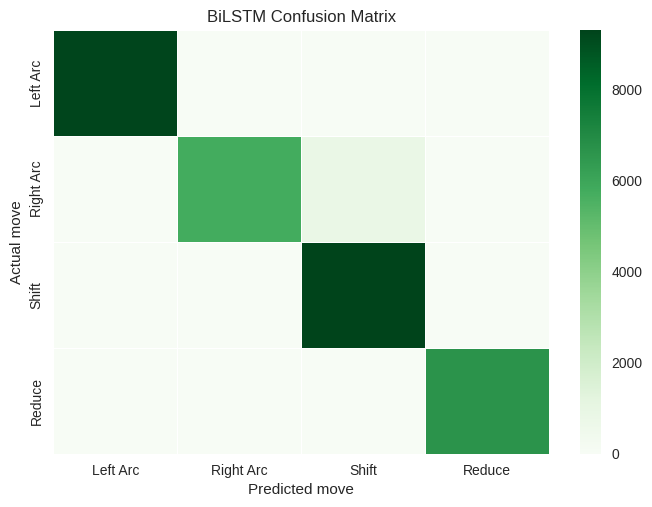

In [55]:
# Use the previous computed confusion matrix between predicted moves and actual available moves
all_labels = ['Left Arc', 'Right Arc', 'Shift', 'Reduce']

# Create the heatmap plot for BiLSTM model, setting the main color and the title
heatmap_moves_bilstm = compute_confusion(confusion_matrix_bilstm, all_labels, 'BiLSTM Confusion Matrix', "Greens")
# Display the plot
pyplot.show()

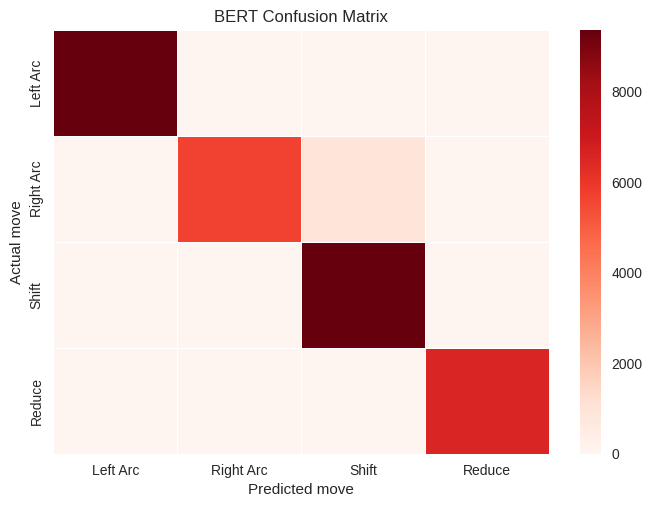

In [32]:
# Create the heatmap plot for BERT model, setting the main color and the title
heatmap_moves_bert = compute_confusion(confusion_matrix_bert, all_labels, 'BERT Confusion Matrix', "Reds")
# Display the plot
pyplot.show()

In [33]:
# This function compute the corresponding table for each model, given a specific confusion matrix
def compute_table(confusion):
  accuracy_class = confusion.diagonal() / confusion.sum(axis=1)
  num_classes = confusion.shape[0]
  true_positives = confusion.diagonal()
  predicted_positives = confusion.sum(axis=0)
  actual_positives = confusion.sum(axis=1)

  precision = true_positives / predicted_positives
  recall = true_positives / actual_positives

  f1_scores = 2 * (precision * recall) / (precision + recall)
  global_f1 = sum(f1_scores) / num_classes

  table = []
  for i, i_accuracy in enumerate(accuracy_class):
      table.append([f"Class {i}", i_accuracy])

  table.append(["F1 score", global_f1])
  table_column = ["Class", "Accuracy"]
  return table, table_column

In [56]:
print(" "*4 + "BiLSTM Table")
bilstm_table, bilstm_table_column = compute_table(confusion_matrix_bilstm)
print(tabulate(bilstm_table, headers=bilstm_table_column, tablefmt="presto"))

print("\n" + " "*6 +"BERT Table")
bert_table, bert_table_column = compute_table(confusion_matrix_bert)
print(tabulate(bert_table, headers=bert_table_column, tablefmt="presto"))

    BiLSTM Table
 Class    |   Accuracy
----------+------------
 Class 0  |   0.999351
 Class 1  |   0.869848
 Class 2  |   0.999893
 Class 3  |   1
 F1 score |   0.971305

      BERT Table
 Class    |   Accuracy
----------+------------
 Class 0  |   0.999893
 Class 1  |   0.86475
 Class 2  |   1
 Class 3  |   1
 F1 score |   0.970493


What is clear by looking at the two confusion matrix is that the **Shift** is often preferred over a **Right Arc**, but not so much with respect to **Left Arc**.

Furthermore, the accuracy that we obtain from the two models shows that:
- **Reduce**, **Left Arc** and **Shift**  moves are very often done correctly.

- **Right Arc** is the most confusing move.

Unexpectedly, the F1 score is more similar than expected even if the result obtained testing on the test set is very different.

### 7.4 - Discussion
The **BiLSTM model** has been adapted to have an architecture that is similar to the ones that are currently in the leaderboards of the SoTA. We tested various combination and we got best results (of course compating the validation set evaluations) with the following set of parameters:
- **LSTM_BATCH_SIZE = 16**
- **EMBEDDING_SIZE = 300**
- **LSTM_SIZE = 300**
- **LSTM_LAYERS = 2**
- **MLP_SIZE = 200**
- **DROPOUT = 0.2**
- **EPOCHS = 30**
- **LR = 0.001**

The **baseline UAS** obtained on test using the best combination of parameters found was of **70.4%**.
We also test using the parameter that was provided in the second laboratory:
- **LSTM_BATCH_SIZE = 16**
- **EMBEDDING_SIZE = 200**
- **LSTM_SIZE = 200**
- **LSTM_LAYERS = 1**

and it's clear that the resulting model performs slightly worse ($\approx 2$%), with respect to the model obtained with the best parameters just described.

The **BERT model** obtained a **UAS** score of **85.7%**. The embeddings of the sentences were extracted by summing the last 4 hidden layers, as suggested in the slides. We also test the model by extracting the embeddings of the sentences only from the last hidden layer, but the final result are slightly worse ($\approx 2$%) compared to the sum of the last 4 hidden layers. This result was obtained using the following parameters, where the majority was retrived by Hugging Face:
- **BERT_BATCH_SIZE = 8**
- **BERT_EMBEDDING_SIZE = 200**
- **BERT_OUT_FEATURES = 768**
- **BERT_MLP_SIZE = 200**
- **BERT_DROPOUT = 0.2**
- **BERT_EPOCHS = 10**
- **BERT_LR = 3e-5**

Furthermore, for both models, we are able to perform the training in less than 40 minutes using google colab. Obviously, if you reduce the number of epochs for training the two models, the training time decrese and this is especially critical with BERT, since each iterations take at least 4 minutes.

The current state-of-the-art (SoTA) has an UAS of **91.47%** for our dataset **"en_gum"**. This result was achived employing the BERT, Flair as pretrained embedding inputs in a strong baseline of UDPipe 2.0, one of the best-performing systems of the CoNLL 2018 Shared Task and an overall winner of the EPE 2018, as you can see in the first PDF link below.

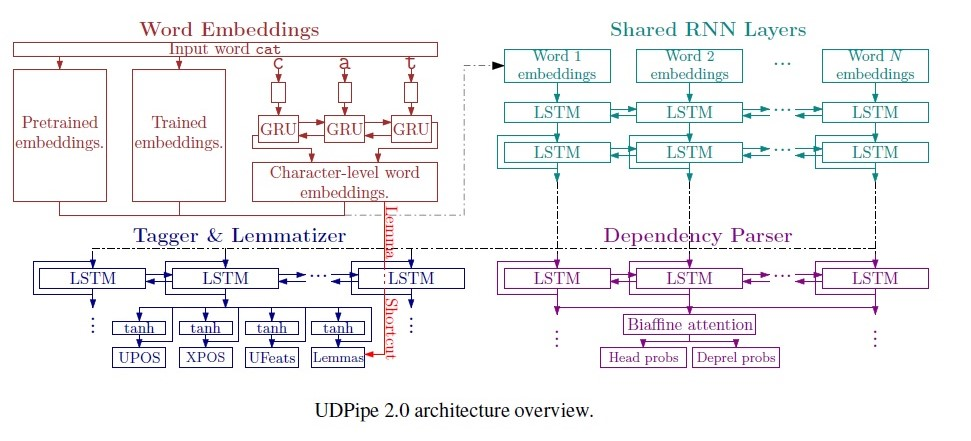


In conclusion, the results we have managed to achieve are very good, even if the leaderboard is about $\approx 6$%  better than our best model.

Finally, comparing our results with the SoTA results obtained by the paper model, we can see that instead of using the model presented by the paper, which is not the latest one, there could be some other papers that implement other models, that seem very promising and manage to achieve an accuracy of **97%**, especially in the Penn Treebank (check the second PDF link below.). Of course, it's very important to note that the size of our dataset (6k) is much smaller compared with the Penn Treebank (46k).

Results of the SoTA were found on:

* https://arxiv.org/pdf/1908.07448v1.pdf
* https://arxiv.org/pdf/1911.03875v3.pdf